# Методы ДП для поиска оптимальной стратегии

Рассмотрим на практике работу методов ДП для поиска оптимальной стратегии, которые обсуждались в лекциях.

### Алгоритм итерации по стратегиям

Реализуем метод итерации по стратегиям для поиска оптимальной стратегии. 
Этот метод представляет собой итерацию следующих двух шагов:

1. оценка стратегии, путём вычисления её функции ценности состояний $v_{\pi}(s)$,
2. улучшение стратегии.

Шаг оценки стратегии у нас уже реализован в коде, это метод `PolicyEvaluation()`. Сделаем лишь одну модификацию кода этого метода, которая позволит устанавливать начальную оценку функции ценности состояний $v_{\pi}(s)$ вручную. Это удобно с той точки зрения, что для обновлённой стратегии начальную оценку функции ценности состояний можно инициализировать по найденной оценке этой фукнции для старой стратегии. Это ускоряет сходимость.

Далее, приведём код для шага улучшения стратегии `PolicyImprovement()`. И напишем метод `IterationByPolicy()`, реализующий алгортим итерации по стратегиям.

Также для удобства, напишем метод `GetOptimalActionsByPolicy()` для получения индексов оптимальных действий из найденной стратегии.

In [9]:
# Оценка стратегии (в параметрах можно передать V, то есть фукнцию ценности старой стратегии)
def PolicyEvaluation(env, policy, V, gamma, theta=1e-4):
    nS = env.observation_space.n # количество различных состояний    
    iteration = 0
    while True:
        delta = 0
        # Вычисление новых оценок для всех состояний
        for state in range(nS):         
            v_s_old = V[state] # запоминаем значение v(s), для его сравнения с обновлённым значением v(s)
            v_s = 0 # для обновлённого значения v(s)         
            act_probs = policy[state]
            for act, act_prob in enumerate(act_probs):
                for next_sr in env.P[state][act]:
                    trans_prob, new_state, reward, _ = next_sr
                    v_s += act_prob * trans_prob * (reward + gamma * V[new_state])
            V[state] = v_s
            # найдём разницу между старым и новым значением v(s)
            delta = np.max([delta, np.abs(V[state] - v_s_old)])
        iteration = iteration + 1
        # Критерий завершения итераций
        if delta < theta:
            break
        if iteration > 2000:
            print("Более 2000 итераций. Стоп.")
            return V
    print("Число итераций: ", iteration)
    return V

# Улучшение стратегии
def PolicyImprovement(env, oldPolicy, V, gamma):
    nS = env.observation_space.n
    nA = env.action_space.n
    # пустой список из нулей для формирования обновлённой стратегии
    newPolicy = np.zeros((nS,nA))
    policy_changed = False
    for state in range(nS):
        q_s = [] # массив для значений q(s,a)
        for act in range(nA):
            q_s_a = 0 # для вычисления q(s,a)
            for next_sr in env.P[state][act]:
                trans_prob, new_state, reward, _ = next_sr
                q_s_a += trans_prob * (reward + gamma * V[new_state])
            q_s.append(q_s_a)
        # ищем максимальные значения, формируем новую стратегию
        mask = q_s == np.max(q_s)
        newPolicy[state] = mask/np.sum(mask)
    
        # np.allclose сравнение числовых массивов с точностью до некоторого допуска
        if not np.allclose(newPolicy[state], oldPolicy[state]):
            policy_changed = True # флаг о том, что стратегия изменилась
    return newPolicy, policy_changed


def IterationByPolicy(env, gamma = 0.9, theta = 1e-4):
    nS = env.observation_space.n
    nA = env.action_space.n 
    # инициализация стратегией равновероятного выбора действий
    policy = np.ones([nS, nA]) / nA
    V = np.zeros(nS)
    iteration = 0
    while True:
        # шаг оценки
        V = PolicyEvaluation(env, policy, V, gamma, theta)
        # шаг улучшения
        policy, changed = PolicyImprovement(env, policy, V, gamma)

        iteration = iteration + 1
        if not changed: #завершить, если нет изменений в стратегии
            break
        if iteration > 1000:
            print("Больше 1000 итераций. Стоп.")
            break
            
    print("Число шагов улучшения стратегии: ", iteration)
    optPolicy = policy
    V_optimal = PolicyEvaluation(env, optPolicy, V, gamma, theta)
    return optPolicy, V_optimal


# Получение оптимальных действий по оптимальной функции ценности состояний
def GetOptimalActionsByPolicy(optPolicy):
    nS = len(optPolicy)
    # пустой список из нулей для записи оптимальных действий
    bestActs = [0]*nS
    for state in range(nS):
        bestActs[state] = np.argwhere(optPolicy[state] == np.max(optPolicy[state])).flatten().tolist()
    return bestActs

### Алгоритм итерации по ценности

Реализуем метод итерации по ценности для поиска оптимальной стратегии. Напомним, что для этого используется уравнение оптимальности Беллмана и итерационный метод для решения этого уравнения.

$V_{k+1}(s) = \max\limits_a \sum\limits_{r\in {\mathcal R}} \sum\limits_{s'\in {\mathcal S}} p(s',r|s,a) (r + \gamma V_k(s'))$

Когда оптимальные значения ценностей $V^*$ найдены, то для определения оптимальной стратегии надо в каждом состоянии выбрать действия, приносящий максимальный доход, а именно:


$\pi^*(s) = \underset{a}{\mathrm{argmin}} \sum\limits_{r\in {\mathcal R}} \sum\limits_{s'\in {\mathcal S}} p(s',r|s,a) (r + \gamma V_k(s'))$

### Задача: реализовать алгоритм итерации по ценности

In [11]:
def IterationByValues(env, gamma, theta = 1e-4):
    nS = env.observation_space.n
    nA = env.action_space.n 
    V = np.zeros(nS)
    iteration = 0
    while True:
        
        ???
        ???
        ???
        
        if iteration > 2000:
            print("Больше 2000 итераций. Стоп.")
            return V
    print("Число итераций: ", iteration)
    return V


# Получение оптимальной стратегии по оптимальной функции ценности состояний
def GetOptimalPolicyByV(env, OptValues, gamma):
    nS = env.observation_space.n
    nA = env.action_space.n 
    # пустой список из нулей для записи оптимальных действий
    optPolicy = np.zeros((nS,nA))

        ???
        ???
        ???

    return optPolicy

### Пример 1

Рассмотрим задачу о сеточном мире размера 4 на 4 клетки из книги Р. Саттона и Э. Барто "Обучение с подкреплением" и найдём оптимальную стратегию действий.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
# подгрузка среды
from custom.env.gridworld import GridWorld4by4

In [7]:
gamma = 1.0
env = GridWorld4by4()
optPolicy, optVal = IterationByPolicy(env, gamma, theta=1e-5)
np.round(optVal,3).reshape(4,4)
print("Оптимальная стратегия: \n",optPolicy)

Число итераций:  141
Число итераций:  3
Число итераций:  1
Число шагов улучшения стратегии:  3
Число итераций:  1
Оптимальная стратегия: 
 [[0.25 0.25 0.25 0.25]
 [1.   0.   0.   0.  ]
 [1.   0.   0.   0.  ]
 [0.5  0.5  0.   0.  ]
 [0.   0.   0.   1.  ]
 [0.5  0.   0.   0.5 ]
 [0.25 0.25 0.25 0.25]
 [0.   1.   0.   0.  ]
 [0.   0.   0.   1.  ]
 [0.25 0.25 0.25 0.25]
 [0.   0.5  0.5  0.  ]
 [0.   1.   0.   0.  ]
 [0.   0.   0.5  0.5 ]
 [0.   0.   1.   0.  ]
 [0.   0.   1.   0.  ]
 [0.25 0.25 0.25 0.25]]


In [9]:
# оптимальные ценности действий
optVal.reshape(4,4)

array([[ 0., -1., -2., -3.],
       [-1., -2., -3., -2.],
       [-2., -3., -2., -1.],
       [-3., -2., -1.,  0.]])

Как было отмечено ранее, выбранная система вознаграждений ведёт к тому, что максимизация дохода в данной задаче предполагает как можно более быстрое движение в заключительные состояния из клеток сеточного мира. А ценности состояний будут означать среднее число шагов из этого состояния до заключительного состояния с обратным знаком при выбранной стратегии. По ответу ясно, что оптимальные значения найдены.

Выведем также оптимальные действия в каждом состоянии:

In [11]:
optActs = GetOptimalActionsByPolicy(optPolicy)
optActs = [optActs[x:x+4] for x in range(0, 16, 4)] 
optActs

[[[0, 1, 2, 3], [0], [0], [0, 1]],
 [[3], [0, 3], [0, 1, 2, 3], [1]],
 [[3], [0, 1, 2, 3], [1, 2], [1]],
 [[2, 3], [2], [2], [0, 1, 2, 3]]]

Далее, найдём оптимальные значения методом итерации по ценности. Результат одинаковый, но в данном случае сходимости гораздо более быстрая.

In [13]:
gamma = 1.0
optVal=IterationByValues(env, gamma, theta=1e-6)
np.round(optVal,3).reshape(4,4)

Число итераций:  4


array([[ 0., -1., -2., -3.],
       [-1., -2., -3., -2.],
       [-2., -3., -2., -1.],
       [-3., -2., -1.,  0.]])

In [15]:
print("Оптимальная стратегия: \n", GetOptimalPolicyByV(env,optVal, gamma))

Оптимальная стратегия: 
 [[0.25 0.25 0.25 0.25]
 [1.   0.   0.   0.  ]
 [1.   0.   0.   0.  ]
 [0.5  0.5  0.   0.  ]
 [0.   0.   0.   1.  ]
 [0.5  0.   0.   0.5 ]
 [0.25 0.25 0.25 0.25]
 [0.   1.   0.   0.  ]
 [0.   0.   0.   1.  ]
 [0.25 0.25 0.25 0.25]
 [0.   0.5  0.5  0.  ]
 [0.   1.   0.   0.  ]
 [0.   0.   0.5  0.5 ]
 [0.   0.   1.   0.  ]
 [0.   0.   1.   0.  ]
 [0.25 0.25 0.25 0.25]]


In [17]:
optPolicy = GetOptimalPolicyByV(env,optVal, gamma)
optActs = GetOptimalActionsByPolicy(optPolicy)
optActs = [optActs[x:x+4] for x in range(0, env.observation_space.n, 4)] 
optActs

[[[0, 1, 2, 3], [0], [0], [0, 1]],
 [[3], [0, 3], [0, 1, 2, 3], [1]],
 [[3], [0, 1, 2, 3], [1, 2], [1]],
 [[2, 3], [2], [2], [0, 1, 2, 3]]]

### Пример 2

Далее, применим реализованные алгоритмы для решения задачи о замёрзшем озере FrozenLake.

In [19]:
import gymnasium as gym
import numpy as np

env = gym.make("FrozenLake-v1") #создание экземпляра среды
env.reset() # инициализация среды

# выведем описания пространств состояний и действий
print("Пространство состояний:", env.observation_space)
print("Пространство действий:", env.action_space)

Пространство состояний: Discrete(16)
Пространство действий: Discrete(4)


Запустим симуляцию со случайными действиями.

In [87]:
import time

env = gym.make("FrozenLake-v1", render_mode='human').unwrapped
env.reset()

while True:
    time.sleep(.2)
    state, reward, terminated, truncated, _ = env.step(env.action_space.sample()) # выбрать действие случайно
    if terminated or truncated:
        break
    
env.close()

Запустим алгоритм поиска оптимальной стратегии по методу итерации по стратегиям.

In [27]:
optPolicy, optVal = IterationByPolicy(env, gamma=1.0, theta=1e-5)
print(np.round(optVal,3).reshape(4,4))
optPolicy

Число итераций:  31
Число итераций:  198
Число итераций:  179
Число шагов улучшения стратегии:  3
Число итераций:  1
[[0.823 0.823 0.823 0.823]
 [0.823 0.    0.529 0.   ]
 [0.823 0.823 0.765 0.   ]
 [0.    0.882 0.941 0.   ]]


array([[1.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 1.  ],
       [0.  , 0.  , 0.  , 1.  ],
       [0.  , 0.  , 0.  , 1.  ],
       [1.  , 0.  , 0.  , 0.  ],
       [0.25, 0.25, 0.25, 0.25],
       [0.5 , 0.  , 0.5 , 0.  ],
       [0.25, 0.25, 0.25, 0.25],
       [0.  , 0.  , 0.  , 1.  ],
       [0.  , 1.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  ],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.  , 0.  , 1.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  ],
       [0.25, 0.25, 0.25, 0.25]])

In [29]:
optActs = GetOptimalActionsByPolicy(optPolicy)
nS = len(env.P)
optActs_show = [ optActs[x:x+4] for x in range(0, nS, 4) ] 
optActs_show

[[[0], [3], [3], [3]],
 [[0], [0, 1, 2, 3], [0, 2], [0, 1, 2, 3]],
 [[3], [1], [0], [0, 1, 2, 3]],
 [[0, 1, 2, 3], [2], [1], [0, 1, 2, 3]]]

Напомним, что нумерация действий значит следующее:

    0: влево
    1: вниз
    2: вправо
    3: вверх
    
Аналогично, применим метод итерации по ценности.

In [31]:
gamma = 1.0
optVal=IterationByValues(env, gamma, theta=1e-5)
np.round(optVal,5).reshape(4,4)

Число итераций:  254


array([[0.82336, 0.82331, 0.82327, 0.82325],
       [0.82338, 0.     , 0.5293 , 0.     ],
       [0.8234 , 0.82344, 0.76463, 0.     ],
       [0.     , 0.88229, 0.94114, 0.     ]])

In [33]:
optPolicy = GetOptimalPolicyByV(env,optVal, gamma)
optActs = GetOptimalActionsByPolicy(optPolicy)
nS = len(env.P)
optActs_show = [ optActs[x:x+4] for x in range(0, nS, 4) ] 
optActs_show

[[[0], [3], [3], [3]],
 [[0], [0, 1, 2, 3], [0, 2], [0, 1, 2, 3]],
 [[3], [1], [0], [0, 1, 2, 3]],
 [[0, 1, 2, 3], [2], [1], [0, 1, 2, 3]]]

In [35]:
optPolicy = GetOptimalPolicyByV(env,optVal, gamma)
optPolicy

array([[1.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 1.  ],
       [0.  , 0.  , 0.  , 1.  ],
       [0.  , 0.  , 0.  , 1.  ],
       [1.  , 0.  , 0.  , 0.  ],
       [0.25, 0.25, 0.25, 0.25],
       [0.5 , 0.  , 0.5 , 0.  ],
       [0.25, 0.25, 0.25, 0.25],
       [0.  , 0.  , 0.  , 1.  ],
       [0.  , 1.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  ],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.  , 0.  , 1.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  ],
       [0.25, 0.25, 0.25, 0.25]])

Запустим симуляцию среды с обученным агентом, который действует по оптимальной стратегии.

In [89]:
import time
from IPython.display import clear_output

env = gym.make("FrozenLake-v1", render_mode='ansi')
nA = env.action_space.n 

state, _ = env.reset()
print(env.render())

while True:
    # выбор действий в соответствии с вероятностями из оптимальной стратегии
    action = np.random.choice(nA, p = optPolicy[state]) 
    state, reward, terminated, truncated, _ = env.step(action)
    
    time.sleep(.2)
    clear_output(wait=True)
    print(env.render())

    if terminated or truncated:
        break
    
print("finish") 

  (Up)
SFFF
FHFH
FFFH
HFFG

finish


Проведём симуляцию на 1000 эпизодах и найдём число успешных эпизодов при оптимальной стратегии и стратегии равновероятного выбора действия.

In [91]:
def play(env, n_episodes, optPolicy):
    for episode in range(n_episodes):
        state, _ = env.reset()
        while True:
            # выбираем действия по стратегии
            action = np.random.choice(nA, p = optPolicy[state]) 
            state, reward, terminated, truncated, _ = env.step(action)
            if terminated or truncated:
                break

Посколько параметр `gamma=1.0`, то нет штрафа за длительное взаимодействие со средой. Для текущей задачи это значит, что агент обучается находить максимально безопасный путь. Поэтому временное ограничение в 100 шагов в среде FrozenLake может превышаться. Для изменения этого временного ограничения можно при создании среды указать `max_episode_steps=1000`. В этом случае временное ограничение будет изменено на 1000 шагов. 

In [93]:
n_episodes = 1000
env = gym.make("FrozenLake-v1", render_mode='ansi', max_episode_steps=1000)
env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=n_episodes)

play(env, n_episodes, optPolicy)
print("Число успешных завершений эпизода: ", sum(env.return_queue))

Число успешных завершений эпизода:  0.0


In [57]:
# равновероятный выбор действия
env.reset()
rand_policy = np.ones([16, 4]) / 4
play(env, n_episodes, rand_policy)
print("Число успешных завершений эпизода: ", sum(env.return_queue))

Число успешных завершений эпизода:  13.0


В среднем около 82% эпизодов удалось завершить успешно. А при стратегии равновероятного выбора завершить эпизод удаётся лишь в среднем при 1.4% случаях.

Можно также найти решения при различных значениях `gamma`. Выше решение найдено при `gamma=1`. Это значит поиск стратегии, которая прокладывает максимально безопасный путь.

Можно также посчитать решение, например, при `gamma=0.9`. Тогда агент будет искать баланс между безопасным путём и длительностью прохождения (в данном случае далёкая награда за успешное завершение будет сильно обесценена). Полученная оптимальная стратегия будет отличаться от оптимальной стратегии при `gamma=1`.

In [61]:
env = gym.make("FrozenLake-v1", render_mode='ansi').unwrapped

optPolicy, optVal = IterationByPolicy(env, gamma=0.9, theta=1e-5)
print(np.round(optVal,3).reshape(4,4))

Число итераций:  21
Число итераций:  46
Число шагов улучшения стратегии:  2
Число итераций:  1
[[0.069 0.061 0.074 0.056]
 [0.092 0.    0.112 0.   ]
 [0.145 0.247 0.3   0.   ]
 [0.    0.38  0.639 0.   ]]


In [63]:
optActs = GetOptimalActionsByPolicy(optPolicy)
nS = len(env.P)
optActs_show = [ optActs[x:x+4] for x in range(0, nS, 4) ] 
optActs_show

[[[0], [3], [0], [3]],
 [[0], [0, 1, 2, 3], [0, 2], [0, 1, 2, 3]],
 [[3], [1], [0], [0, 1, 2, 3]],
 [[0, 1, 2, 3], [2], [1], [0, 1, 2, 3]]]

In [67]:
n_episodes = 1000
env = gym.make("FrozenLake-v1", render_mode='ansi', max_episode_steps=1000)
env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=n_episodes)

play(env, n_episodes, optPolicy)
print("Число успешных завершений эпизода: ", sum(env.return_queue))

Число успешных завершений эпизода:  780.0


Среднее число успешных завершений теперь около 78%.

### Пример 3

Рассмотрим задачу FrozenLake с полем 8 на 8 клеток. Правила аналогичны задаче FrozenLake с полем 4 на 4, просто поле имеет теперь больший размер.

In [4]:
import gymnasium as gym
import numpy as np

env = gym.make("FrozenLake-v1", map_name="8x8")
env.reset() # инициализация среды

# выведем описания пространств состояний и действий
print("Пространство состояний:", env.observation_space)
print("Пространство действий:", env.action_space)

Пространство состояний: Discrete(64)
Пространство действий: Discrete(4)


Запустим симуляцию среды со случайными действиями.

In [95]:
import time

env = gym.make("FrozenLake-v1", map_name="8x8", render_mode = 'human').unwrapped
env.reset()

while True:
    time.sleep(.2)
    state, reward, terminated, truncated, _ = env.step(env.action_space.sample()) # выбрать действие случайно
    if terminated or truncated:
        break
    
env.close()

Как и ранее, сначала применим метод итерации по стратегиям.

In [107]:
env = gym.make("FrozenLake-v1", map_name="8x8").unwrapped
env.reset()

optPolicy, optVal = IterationByPolicy(env, gamma=1.0, theta=1e-3)
print(np.round(optVal,2).reshape(8,8))

Число итераций:  14
Число итераций:  118
Число итераций:  67
Число итераций:  50
Число итераций:  42
Число итераций:  29
Число итераций:  4
Число итераций:  1
Число шагов улучшения стратегии:  8
Число итераций:  1
[[1.   1.   1.   1.   1.   1.   1.   1.  ]
 [1.   1.   1.   1.   1.   1.   1.   1.  ]
 [0.99 0.97 0.92 0.   0.85 0.94 0.98 1.  ]
 [0.98 0.92 0.79 0.47 0.62 0.   0.94 1.  ]
 [0.97 0.81 0.53 0.   0.54 0.61 0.85 1.  ]
 [0.96 0.   0.   0.17 0.38 0.44 0.   1.  ]
 [0.96 0.   0.19 0.12 0.   0.33 0.   1.  ]
 [0.96 0.7  0.44 0.   0.28 0.55 0.78 0.  ]]


In [99]:
optPolicy = GetOptimalPolicyByV(env, optVal, gamma = 1.0)
optActs = GetOptimalActionsByPolicy(optPolicy)
nS = len(env.P)
optActs_show = [ optActs[x:x+8] for x in range(0, nS, 8) ] 
optActs_show

[[[1], [2], [2], [2], [2], [2], [2], [2]],
 [[3], [3], [3], [3], [3], [3], [3], [2]],
 [[0], [3], [0], [0, 1, 2, 3], [2], [3], [3], [2]],
 [[0], [0], [0], [1, 3], [0], [0, 1, 2, 3], [2], [2]],
 [[0], [3], [0, 3], [0, 1, 2, 3], [2], [1], [3], [2]],
 [[0], [0, 1, 2, 3], [0, 1, 2, 3], [1, 2], [3], [0], [0, 1, 2, 3], [2]],
 [[0], [0, 1, 2, 3], [1, 2], [0, 3], [0, 1, 2, 3], [0, 2], [0, 1, 2, 3], [2]],
 [[0], [1], [0], [0, 1, 2, 3], [1, 2], [2], [1], [0, 1, 2, 3]]]

Применим также метод итерация по ценности.

In [79]:
gamma = 1.0
optVal=IterationByValues(env, gamma, theta=1e-4)
np.round(optVal,2).reshape(8,8)

Число итераций:  343


array([[1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ],
       [1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ],
       [1.  , 0.98, 0.92, 0.  , 0.86, 0.95, 0.98, 1.  ],
       [1.  , 0.93, 0.8 , 0.47, 0.62, 0.  , 0.94, 1.  ],
       [1.  , 0.82, 0.54, 0.  , 0.54, 0.61, 0.85, 1.  ],
       [1.  , 0.  , 0.  , 0.17, 0.38, 0.44, 0.  , 1.  ],
       [1.  , 0.  , 0.19, 0.12, 0.  , 0.33, 0.  , 1.  ],
       [0.99, 0.73, 0.46, 0.  , 0.28, 0.55, 0.78, 0.  ]])

In [81]:
optPolicy = GetOptimalPolicyByV(env,optVal, gamma)
optActs = GetOptimalActionsByPolicy(optPolicy)
#optActs_show = [ optActs[x:x+8] for x in range(0, env.nS, 8) ] 

Запустим симуляцию среды с обученным агентом, который действует по оптимальной стратегии.

In [83]:
import time
from IPython.display import clear_output

env = gym.make("FrozenLake-v1", map_name="8x8", render_mode='ansi', max_episode_steps=1000)

nA = env.action_space.n 
state, _ = env.reset()
print(env.render())

while True:
    # выбор действий в соответствии с вероятностями из оптимальной стратегии
    action = np.random.choice(nA, p = optPolicy[state]) 
    state, reward, terminated, truncated, _ = env.step(action)
    
    time.sleep(.2)
    clear_output(wait=True)
    print(env.render())

    if terminated or truncated:
        break
    
print("finish") 

  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

finish


Проведём симуляцию на 1000 эпизодах.

In [109]:
def play(env, n_episodes, optPolicy):
    for episode in range(n_episodes):
        nA = env.action_space.n 
        state, _ = env.reset()
        while True:
            # выбираем действия по стратегии
            action = np.random.choice(nA, p = optPolicy[state]) 
            state, reward, terminated, truncated, _ = env.step(action)
            if terminated or truncated:
                break

In [117]:
n_episodes = 100
env = gym.make("FrozenLake-v1", map_name="8x8", render_mode='ansi', max_episode_steps=1000)
env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=n_episodes)

play(env, n_episodes, optPolicy)
print("Число успешных завершений эпизода: ", sum(env.return_queue))

Число успешных завершений эпизода:  100.0


То есть в этой задаче оптимальная стратегия всегда позволяет добраться до целевой клетки.

### Пример 4 

Рассмотрим задачу об управлении такси из библиотеки `gymnasium`. Эта среда также имеет полное описание динамики с помощью словаря `env.P`.

Среда представляет собой клеточное поле в виде квадрата 5 на 5 клеток, на котором отмечены 4 клетки R, G, Y, B (сокращения от названий цветов). В одной из этих клеток, выбранной случайным образом, находится пассажир. И в одной и трёх оставшихся клеток находится место, куда пассажир хочет добраться на такси.

Такси может находится в одной из 25 клеток, пассажир может быть в такси или в одной из 4-х выделенных клеток и точка назначения может быть в одной из выделенных клеток. Эти три параметра задают весь набор состояний. То есть общее число состояний равно $25 *5 *4=500.$
Таким образом, состояние среды представляет собой индекс 1 до 500.

Есть 6 возможных действий: 

    движение такси вверх, вниз, влево, вправо, а также подобрать пассажира и высадить пассажира.
	
Возможные вознаграждения следующие:

    -1 за временной шаг, 
    +20 за успешную посадку\высадку, 
    -10 за посадку\высадку в неправильных клетках.

Эпизод заканчивается, когда пассажир высажен в нужной клетке, либо время взаимодействия превышает 200 временных шагов.

In [5]:
import gymnasium as gym
import numpy as np
env = gym.make("Taxi-v3")
env.reset()

# выведем описания пространств состояний и действий
print("Пространство состояний:", env.observation_space)
print("Пространство действий:", env.action_space)

Пространство состояний: Discrete(500)
Пространство действий: Discrete(6)


Запустим симуляцию со случайными действями. Опять же доступно два варианта визуализации: графическая и текстовая.

In [ ]:
import time

env = gym.make("Taxi-v3", render_mode = 'human', max_episode_steps = 100)
env.reset()

while True:   
    time.sleep(.1)
    state, reward, terminated, truncated, _ = env.step(env.action_space.sample()) # выбрать действие случайно
    if terminated or truncated:
        break
env.close()

In [3]:
import time
from IPython.display import clear_output

env = gym.make("Taxi-v3", render_mode='ansi', max_episode_steps = 100)
env.reset()
print(env.render())

while True:       
    state, reward, terminated, truncated, _ = env.step(env.action_space.sample()) # выбрать действие случайно
    
    time.sleep(.1)
    clear_output(wait=True)      
    print(env.render())
    
    if terminated or truncated:
        break

env.close()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)



Применим метод итерации по стратегиям для обучения агента оптимальной стратегии.

In [13]:
env = gym.make("Taxi-v3", render_mode='ansi').unwrapped
env.reset()

optPolicy, optVal = IterationByPolicy(env, gamma=0.95, theta=1e-3)

Число итераций:  134
Число итераций:  155
Число итераций:  58
Число итераций:  6
Число итераций:  85
Число итераций:  45
Число итераций:  32
Число итераций:  54
Число итераций:  30
Число итераций:  31
Число итераций:  2
Число шагов улучшения стратегии:  11
Число итераций:  1


In [19]:
optActs = GetOptimalActionsByPolicy(optPolicy)

Применим метод итерации по ценности для обучения агента оптимальной стратегии.

In [131]:
gamma = 0.95
optVal=IterationByValues(env, gamma, theta=1e-5)
#np.round(optVal,2)

Число итераций:  146


In [133]:
optPolicy = GetOptimalPolicyByV(env,optVal, gamma)
optPolicy

array([[0. , 0. , 0. , 0. , 1. , 0. ],
       [0. , 0. , 0. , 0. , 1. , 0. ],
       [0. , 0. , 0. , 0. , 1. , 0. ],
       ...,
       [0. , 1. , 0. , 0. , 0. , 0. ],
       [0. , 0.5, 0. , 0.5, 0. , 0. ],
       [0. , 0. , 0. , 1. , 0. , 0. ]])

Запустим симуляцию среды с обученным агентом, который действует по оптимальной стратегии.

In [25]:
import time
from IPython.display import clear_output

env = gym.make("Taxi-v3", render_mode = 'ansi')
nA = env.action_space.n 

state, _ = env.reset()
print(env.render())

while True:
    # выбор действий в соответствии с вероятностями из оптимальной стратегии
    action = np.random.choice(nA, p = optPolicy[state]) 
    state, reward, terminated, truncated, _ = env.step(action)
    
    time.sleep(.2)
    clear_output(wait=True)
    print(env.render())
    
    if terminated or truncated:
        break
    
print("finish") 

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

finish


In [137]:
# симуляция с рендерингом
env = gym.make("Taxi-v3", render_mode = 'human')
nA = env.action_space.n 

state, _ = env.reset()

while True:
    # выбор действий в соответствии с вероятностями из оптимальной стратегии
    action = np.random.choice(nA, p = optPolicy[state]) 
    state, reward, terminated, truncated, _ = env.step(action)
    if terminated or truncated:
        break

finish


Проведём также симуляцию на большом числе эпизодов. Будем записывать полученные доходы и выведем гистограмму распределения доходов.

In [29]:
def play(env, n_episodes, optPolicy):
    for episode in range(n_episodes):
        nA = env.action_space.n 
        state, _ = env.reset()
        while True:
            # выбираем действия по стратегии
            action = np.random.choice(nA, p = optPolicy[state]) 
            state, reward, terminated, truncated, _ = env.step(action)
            if terminated or truncated:
                break

In [31]:
n_episodes = 10000
env = gym.make("Taxi-v3")
env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=n_episodes)

play(env, n_episodes, optPolicy)

Средний доход за эпизод равен: 7.9479
Минимальный доход за эпизод равен: 3.0
Максимальный доход за эпизод равен: 15.0


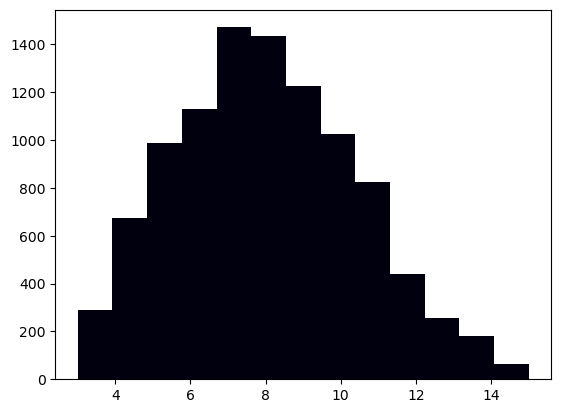

In [141]:
print('Средний доход за эпизод равен:', np.mean(env.return_queue))
print('Минимальный доход за эпизод равен:', np.min(env.return_queue))
print('Максимальный доход за эпизод равен:', np.max(env.return_queue))

import matplotlib.pyplot as plt
plt.hist(env.return_queue, bins=13, color='#00000f')
plt.show()

Можно отметить, что минимальный доход за эпизод равен 3, это соответствует наихудшему начальному состоянию, когда такси требуется проехать максимальное число клеток.

Можно также найти наилучший средний доход за 100 эпизодов, сделав несколько прогонов этих 100 эпизодов.

In [75]:
best = 0
for i in np.arange(100):
    gains = play(env, 100, optPolicy)
    avg = np.mean(gains)
    if avg>best:
        best = avg
        print(best)

7.54
7.75
8.57
